# Домашнее задание 1

В данной домашке мы немного поупражняемся с обработкой временных данных и базовыми моделями. В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с ликвидностью одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день. Данные достаточно сложные и хорошую модель на них построить непросто, но в учебных целях подойдут.

#### Описание бизнес-процесса, связанного с рядом.

Прогнозная величина позволяет установить сальдо поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 




##### 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Какова частотность (frequency) данных? Не спешите отвечать на этот вопрос и посмотрите на данные внимательно. Выберите подходящий под данные оффсет и сделайте ресэмпл ряда к этому оффсету.

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import holidays
import requests

In [298]:
path = 'data.csv'
ts = pd.read_csv(path, index_col=0)
ts.index = pd.to_datetime(ts.index, dayfirst=True)

In [299]:
# сначала данные идут с частотностью 2 часа. С какого то момента частотность меняется на дневную. Преобразуем ряд.

ts_daily = ts.resample('B').sum()

##### 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? (Хинт: на коррелограммах разностей ряда некоторые детали могут быть более чёткими)

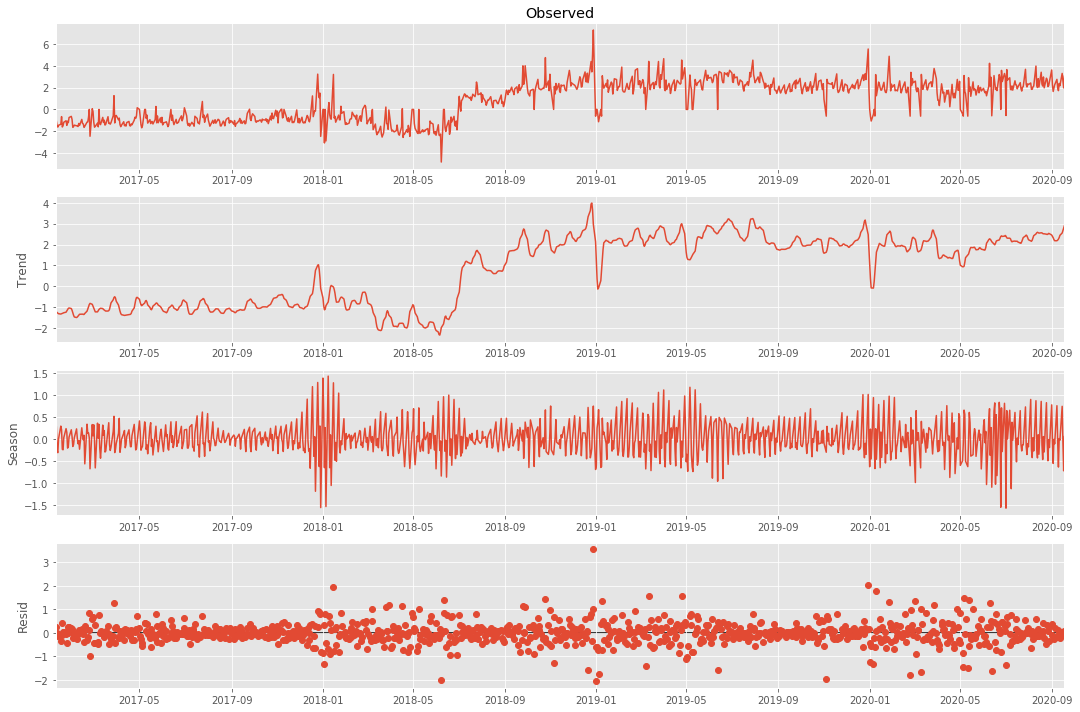

In [300]:
plt.rcParams["figure.figsize"] = (15,10)

# для выявления тренда, сезонности применим к ряду STL разложение.

stl = STL(ts_daily)
res = stl.fit()
res.plot();

определяем отсутсвие тренда и наличие сезонности в данных. Циклическаая компонента присутсвует, но слабо выражена (на графике изображено только три ярковыраженных пика и спада). Ряд нестационарен из-за структурного изменения, имеющего место в период между июнем и сентрябрем 2018 года. Это противоречит определению стационарности в широком смысле. Если разбить ряд на два ряда до структурного изменения и после, то мат.ожидание и дисперсия рядов будут статистически значимо отличаться друг от друга. 

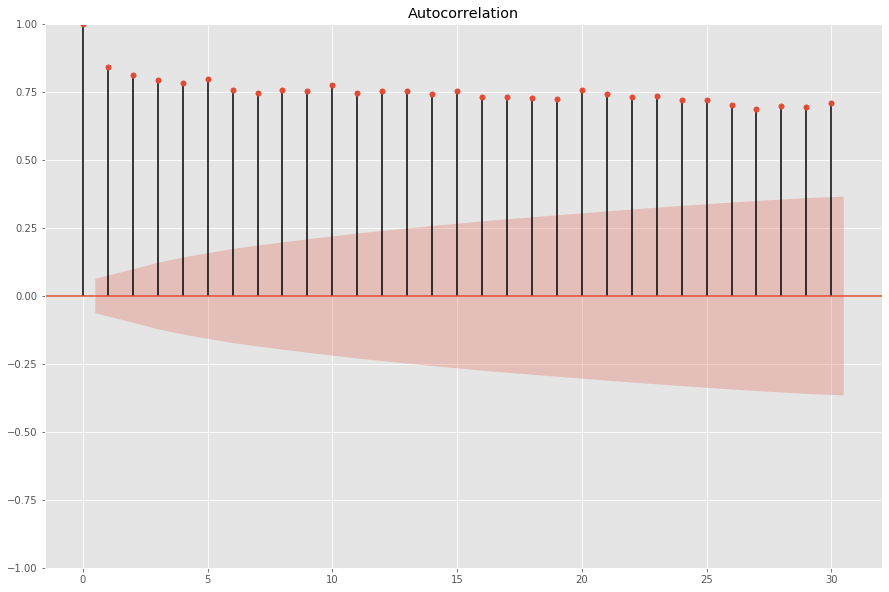

In [301]:
plot_acf(ts_daily);

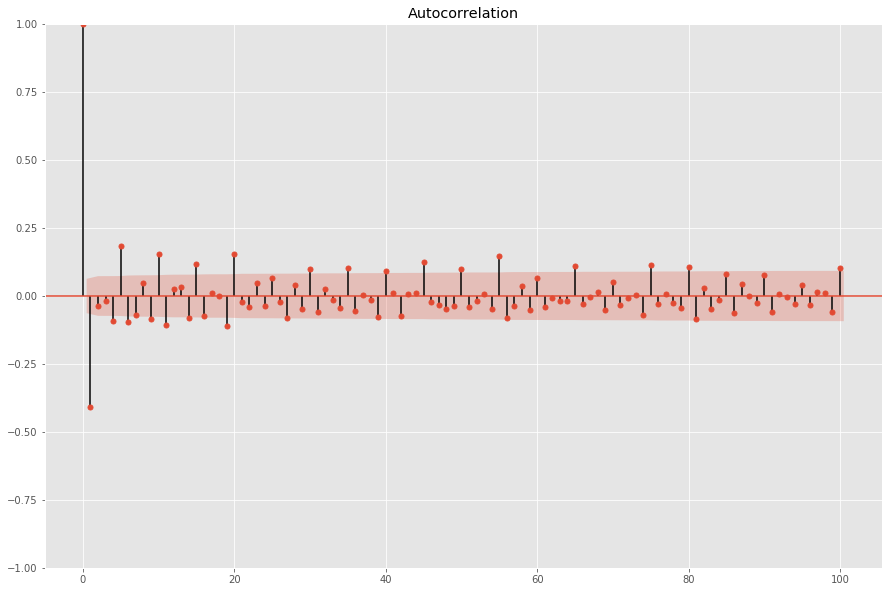

In [302]:
plot_acf(ts_daily['Target'].diff().dropna(), lags=100);

по графику автокорреляционной функции определяем наличие недельной сезонности в данных, а также нестационарность ряда из-за медленного убывания ACF. Так же большое значение имеет месячный лаг. 

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


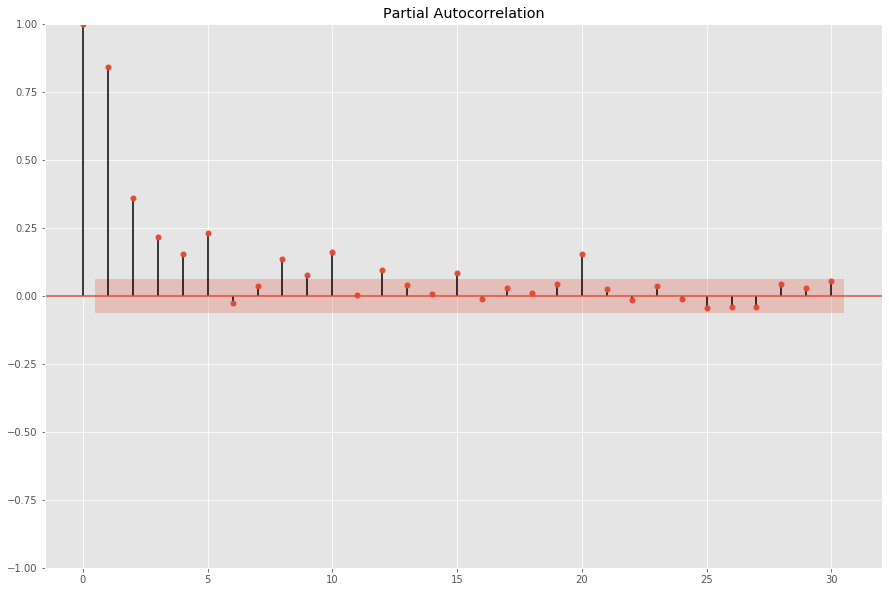

In [303]:
plot_pacf(ts_daily);

график pacf также наталкивает на мысль о нестационарности ряда. 

In [304]:
# окончательно удостоверимся в нестационарности с помощью теста Дики-Фуллера. 

test = adfuller(ts_daily)
print('adf:', test[0])
print('p-value:', test[1])
print('critical values:', test[4])
if test[0] > test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -1.3550022089765208
p-value: 0.6036485850928641
critical values: {'1%': -3.4372961556318304, '5%': -2.864606557310281, '10%': -2.568402813173298}
есть единичные корни, ряд не стационарен


##### 3) Генерация признаков (3 балла)

Внимание! При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе).


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее.

1) Календарные фичи (по 0.15 балла за пункт кроме последнего):
<ul>
<li>Индикатор того, что текущий день праздник</li>
<li>Индикатор того, что предыдущий день праздник</li>
<li>Индикатор того, что следующий день праздник </li>
<li>Индикатор того, что предыдущий день выходной</li>
<li>Индикатор того, что следующий день выходной </li>
<li>В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.</li>
<li>Бонус! (1 балл) Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате не представляется возможным, но это весьма сильная фича.</li>
</ul>

2) Лаги таргета (до 5 разных). (0.1 за все сразу вне зависимости от количества) 

3) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике</li>
<li>Ставки Mosprime, все 7 показателей. Есть на сайте Национальной Финансовой Ассоциации</li>
</ul>

4) Придумайте сами 2 различных фичи (по 0.25 за каждую). Выбор каждой фичи кратко обоснуйте.

In [305]:
rus_holidays = holidays.Russia()
ts_daily['is_holiday'] = ts_daily.index.to_series().apply(lambda x: x in rus_holidays)
ts_daily['prev_holiday'] = ts_daily['is_holiday'].shift(1)
ts_daily['next_holiday'] = ts_daily['is_holiday'].shift(-1) 
ts_daily['previous_is_weekend'] = ts_daily.index.weekday == 0
ts_daily['next_is_weekend'] = ts_daily.index.weekday == 4
ts_daily.dropna(inplace=True)

In [306]:
ts_daily.iloc[:,1:] = ts_daily.iloc[:,1:].astype('int')

In [307]:
# определяем дату структурного изменения

ts_daily.loc['2018-06-20':'2018-07-10']

,Target,is_holiday,prev_holiday,next_holiday,previous_is_weekend,next_is_weekend
Date,,,,,,
2018-06-20,-1.948896,0,0,0,0,0
2018-06-21,-0.694365,0,0,0,0,0
2018-06-22,-1.146404,0,0,0,0,1
2018-06-25,-0.635892,0,0,0,1,0
2018-06-26,-1.431446,0,0,0,0,0
2018-06-27,-1.540736,0,0,0,0,0
2018-06-28,-1.069335,0,0,0,0,0
2018-06-29,-1.877412,0,0,0,0,1
2018-07-02,1.202807,0,0,0,1,0


In [308]:
# создаем индикатор структурного изменения.

ts_daily['struc_change'] = np.where(ts_daily.index > '2018-07-01', 1, 0)

In [309]:
# определяем налоговые и бухгалтерские дни по календарю для юридических лиц. Деятельность банков ежедневно мониторится 
# регулятором, поэтому для банков бух. дней гораздо больше, чем для обычных юр. лиц. В качестве упрощения представим, 
# что бух. дни банков совпадают с днями для юр. лиц. 

accounting = pd.read_csv('accounting.csv', sep=';').dropna()
accounting['Date'] = pd.to_datetime(accounting['Date'], dayfirst=True)
accounting = accounting.set_index('Date')

In [310]:
ts_daily = ts_daily.merge(accounting, how='left', on='Date')

In [311]:
# определяем лаги. 

ts_daily['y_L1'] = ts_daily['Target'].shift(1)
ts_daily['y_L3'] = ts_daily['Target'].shift(3)
ts_daily['y_L4'] = ts_daily['Target'].shift(4)
ts_daily['y_L7'] = ts_daily['Target'].shift(7)
ts_daily['y_L31'] = ts_daily['Target'].shift(31)

In [312]:
# парсим данные по ключевой ставке с сайта ЦБ. 

url = "https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=17.09.2020"

r = requests.get(url)
df_list = pd.read_html(r.text, thousands = None)
df = df_list[0]
df.columns = ['Date','keyrate']
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

In [313]:
ts_daily = ts_daily.merge(df, how='left', on='Date')
ts_daily['keyrate'].fillna(method='ffill', inplace=True) # заполняю пропуски последним известным значением. 
ts_daily['keyrate'] = ts_daily['keyrate'].shift(1)

In [314]:
# данные по обменному курсу беру с сайта http://mfd.ru/currency/?currency=USD&from=09.01.2017&till=17.09.2020

exchange_dollar = pd.read_csv('mfdexport.csv', sep=';')
exchange_dollar['Date'] = pd.to_datetime(exchange_dollar['Date'], dayfirst=True)
exchange_dollar.set_index('Date', inplace=True)
ts_daily = ts_daily.merge(exchange_dollar, how='left', on='Date')
ts_daily['USD'].fillna(method='ffill', inplace=True) 
ts_daily['USD'] = ts_daily['USD'].shift(1)

In [315]:
# данные по ставке моспрайм беру с сайта Национальной Финансовой Ассоциации. 

mosprime = pd.read_csv('mosprime.csv', sep=';', header=0, skiprows=1, encoding = 'unicode_escape')
mosprime['Date'] = pd.to_datetime(mosprime['Date'], dayfirst=True)
mosprime.set_index('Date', inplace=True)
ts_daily = ts_daily.merge(mosprime, how='left', on='Date')
ts_daily.loc[:,'ON':'6M'] = ts_daily.loc[:,'ON':'6M'].fillna(method='ffill') 
ts_daily.loc[:, 'ON':'6M'] = ts_daily.loc[:, 'ON':'6M'].shift(1)

In [316]:
# в качестве фичи я беру индекс РТС. Выбор обоснован тем фактом, что индекс чувствителен на макроэкономическую обстановку,
# которая должна влиять на сальдо ликвидности нашего банка (иностранные вкладчики будут закрывать депозитные счета в случае 
# неблагоприятного политического и экономического фона в России)

rts_index = pd.read_csv('security.csv', sep=';')
rts_index['Date'] = pd.to_datetime(rts_index['Date'], dayfirst=True)
rts_index.set_index('Date', inplace=True)

In [317]:
ts_daily = ts_daily.merge(rts_index, how='left', on='Date')
ts_daily['CLOSE']=ts_daily['CLOSE'].fillna(method='ffill')
ts_daily['CLOSE']=ts_daily['CLOSE'].shift(1)

In [318]:
# раширяющееся окно в нашем случае не подойдет, т.к. оно будет долго подстраиваться под структурное изменение в середине ряда. 
# применяю скользящее среднее небольшой длины. 

ts_daily['rolling_mean'] = ts_daily['Target'].rolling(7).mean().shift(1)

In [319]:
ts_daily = ts_daily.dropna()
ts_daily['Accounting Day'] = ts_daily['Accounting Day'].astype('int')

In [320]:
ts_daily

,Target,is_holiday,prev_holiday,next_holiday,previous_is_weekend,next_is_weekend,struc_change,Accounting Day,y_L1,y_L3,...,USD,ON,1W,2W,1M,2M,3M,6M,CLOSE,rolling_mean
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-22,-0.708926,0,0,1,0,0,0,0,-1.145739,-1.545918,...,"58,0967","10,41","10,44","10,48","10,49","10,5","10,5","10,48","1161,65",-1.292722
2017-02-23,0.000000,1,0,0,0,0,0,0,-0.708926,-1.166033,...,"57,859","10,36","10,43","10,47","10,49","10,5","10,5","10,48","1146,01",-1.263136
2017-02-24,-2.465152,0,1,0,0,1,0,0,0.000000,-1.145739,...,"57,4762","10,36","10,43","10,47","10,49","10,5","10,5","10,48","1146,01",-1.078314
2017-02-27,0.068397,0,0,0,1,0,0,1,-2.465152,-0.708926,...,"57,4762","10,36","10,43","10,47","10,49","10,5","10,5","10,48","1129,09",-1.240139
2017-02-28,-0.202217,0,0,0,0,0,0,0,0.068397,0.000000,...,"57,4762","10,38","10,43","10,48","10,48","10,49","10,49","10,48","1117,29",-0.994767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,2.385552,0,0,0,0,0,1,0,1.726324,2.762902,...,"75,9645","4,38","4,43","4,44","4,55","4,59","4,68","4,7","1201,34",2.092489
2020-09-11,2.180332,0,0,0,0,1,1,0,2.385552,2.008578,...,"76,0713","4,36","4,45","4,45","4,52","4,57","4,66","4,68","1216,59",2.110355
2020-09-14,3.307929,0,0,0,1,0,1,0,2.180332,1.726324,...,"75,5274","4,36","4,45","4,46","4,5","4,56","4,65","4,67","1223,05",2.186091


##### 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [321]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [322]:
obj_col = ts_daily.loc[:,'keyrate':'CLOSE'].columns
for column in obj_col:
    ts_daily[column] = ts_daily[column].apply(lambda x: x.replace(',','.')).astype(float)

In [323]:
y = ts_daily['Target']
X = ts_daily.iloc[:,1:]

In [324]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)

4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. Метрика -- MAPE. 

In [325]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor

In [326]:
model = GradientBoostingRegressor(learning_rate=0.31, n_estimators=400)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)

0.42841079429483836

In [327]:
dict(zip(X.columns, model.feature_importances_))

{'is_holiday': 0.021461169030206836,
 'prev_holiday': 0.002499264369880027,
 'next_holiday': 0.003082786950925454,
 'previous_is_weekend': 0.013329529803378074,
 'next_is_weekend': 0.0020018807803262513,
 'struc_change': 0.6743241231938304,
 'Accounting Day': 0.012512333081382613,
 'y_L1': 0.1277611886379068,
 'y_L3': 0.010627835200819263,
 'y_L4': 0.020906812273112082,
 'y_L7': 0.00858773168431499,
 'y_L31': 0.010146811465787988,
 'keyrate': 0.0071801208881356795,
 'USD': 0.007305889947630673,
 'ON': 0.006257348571447984,
 '1W': 0.0023786040126852824,
 '2W': 0.001688959183211274,
 '1M': 0.0027219253830730664,
 '2M': 0.006736248493135048,
 '3M': 0.008230750834742092,
 '6M': 0.0028232344734201624,
 'CLOSE': 0.012835800878316714,
 'rolling_mean': 0.034599650862331126}

4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна (по сути, фичу первого лага таргета). Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [328]:
naive_forecast = X_test['y_L1']
mean_absolute_percentage_error(y_test, naive_forecast)

0.4810700430258035

4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

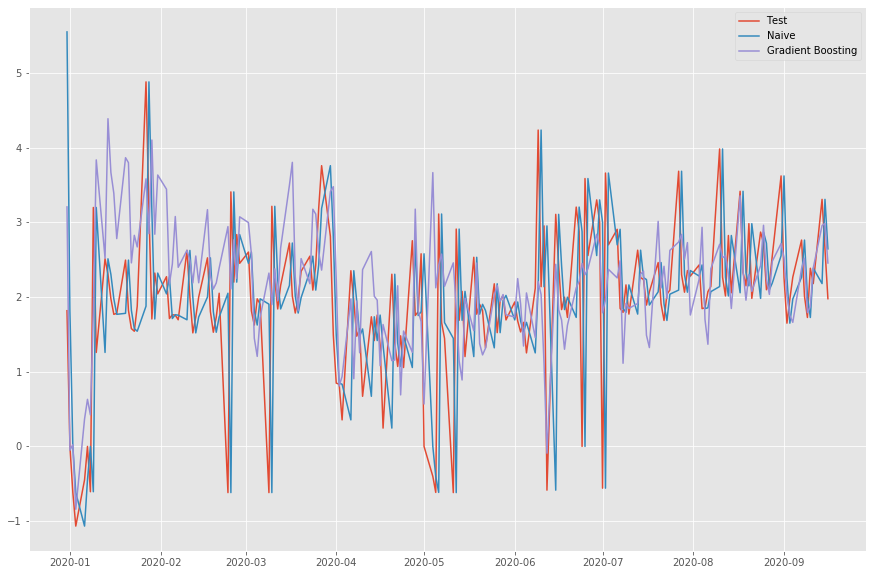

In [329]:
plt.plot(y_test, label = 'Test')
plt.plot(naive_forecast, label='Naive')
plt.plot(y_pred, label='Gradient Boosting')
plt.legend(); ##

##### Бонус! 

+ +1 балл за MAPE на тесте ниже 0.25. Не засчитывается при наличии утечек в данных.
+ +2 балла за MAPE на тесте ниже 0.20. Не засчитывается при наличии утечек в данных.

Если необходимо, можете добавить новые фичи, но в зачёт блока генерации фичей они не пойдут.

##### 5) Повтор препроцессинга (0 баллов)

Повторите разбиение на трейн и тест. Размер теста: 15 наблюдений. Оставьте в модели только календарные фичи и лаги таргета. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

In [330]:
ts_resampled = ts.resample('B').sum()
ts_resampled['y_L1'] = ts_resampled['Target'].shift(1) 
ts_resampled['y_L2'] = ts_resampled['Target'].shift(2) 
ts_resampled['y_L3'] = ts_resampled['Target'].shift(3) 
ts_resampled['y_L4'] = ts_resampled['Target'].shift(4) 
ts_resampled['y_L5'] = ts_resampled['Target'].shift(5)
ts_resampled['is_holiday'] = ts_resampled.index.to_series().apply(lambda x: x in rus_holidays)
ts_resampled['prev_holiday'] = ts_resampled['is_holiday'].shift(1)
ts_resampled['next_holiday'] = ts_resampled['is_holiday'].shift(-1)
ts_resampled['previous_is_weekend'] = ts_resampled.index.weekday == 1
ts_resampled['next_is_weekend'] = ts_resampled.index.weekday == 4
ts_resampled['struc_change'] = np.where(ts_resampled.index > '2018-07-01', 1, 0)
ts_resampled = ts_resampled.merge(accounting, how='left', on='Date')
ts_resampled.dropna(inplace=True)
ts_resampled.iloc[:,6:] = ts_resampled.iloc[:,6:].astype('int')

In [331]:
y = ts_resampled['Target']
X = ts_resampled.iloc[:,1:]

In [332]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=15)

##### 6) Рекурсивная стратегия (2.5 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

In [333]:
# fit

gb = GradientBoostingRegressor()
gb.fit(X_train.to_numpy(), y_train.to_numpy())

# predict

forecast_origin = '2020-08-27'
forecast_horizon = 15
y_pred_recursive = np.array([])
X_lagged = X_test.iloc[:, :5].loc[forecast_origin].to_numpy()

for i in np.arange(forecast_horizon):
    
    X_test_exog = X_test.iloc[i, 5:].to_numpy()
    X_test_i = np.concatenate([X_lagged, X_test_exog]).reshape(1, -1)
    y_pred_recursive = np.append(y_pred_recursive, gb.predict(X_test_i))
    X_lags_shifted = pd.Series(X_lagged).shift(1).dropna().to_numpy()
    X_lagged = np.hstack([y_pred[i], X_lags_shifted])

mean_absolute_percentage_error(y_pred_recursive, y_test)

0.38229529291083775

##### 7) Прямая стратегия (2 балла)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Прямую стратегию необходимо написать вручную!

 Реализуйте прямое прогнозирование на 15 шагов с помощью вашей любимой регрессионной модели.

In [334]:
# fit
forecast_origin = '2020-08-27'
forecast_horizon = 15
models = []

X_lagged = X_train.iloc[:929, :5].to_numpy()

for i in np.arange(forecast_horizon):
    
    X_exog = X_train.iloc[i:929+i, 5:].to_numpy()
    X_train_i = np.concatenate([X_lagged, X_exog], axis=1)
    gb = GradientBoostingRegressor()
    gb.fit(X_train_i, y_train[i:929+i].to_numpy())
    models.append(gb)

# predict

X_lagged = X_test.iloc[0, :5].to_numpy()
y_pred_direct = np.array([])

for i in np.arange(forecast_horizon):
    
    X_test_exog = X_test.iloc[i, 5:].to_numpy()
    X_test_i = np.concatenate([X_lagged, X_test_exog]).reshape(1, -1)
    y_pred_direct = np.append(y_pred_direct, models[i].predict(X_test_i))

mean_absolute_percentage_error(y_pred_direct, y_test)

0.19894610530190973

##### 8) Результаты (0.5 балла)

Визуализируйте прогнозы двух стратегий и тестовые данные на одном графике. Подсчитайте MAPE прогнозов двух моделей. Какая оказалась лучше?

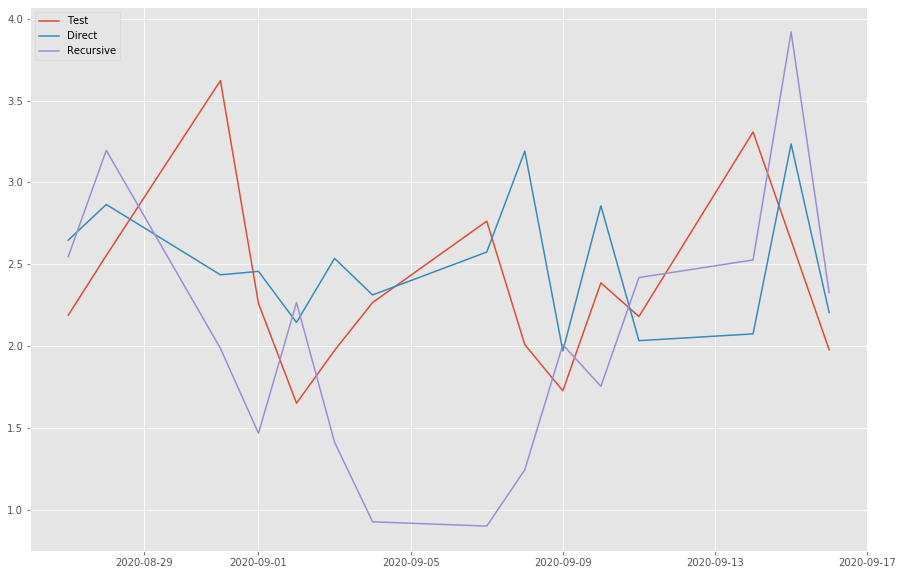

In [335]:
plt.plot(y_test.index, y_test, label = 'Test')
plt.plot(y_test.index, y_pred_direct, label='Direct')
plt.plot(y_test.index, y_pred_recursive, label='Recursive')
plt.legend();

МАПЕ рекурсивной стратегии выше, чем МАПЕ прямой. Это объясняется тем, что прогноз на каждый последующий шаг накапливает ошибку предыдущего шага

##### 9) Скиньте последний мем, который заставил посмеяться (Респект ассистента и семинариста)

In [336]:
# ༼ つ ◕_◕ ༽つ